# 5.1. Introduction to JAX

> **Author**: Gustavo Leite / **Date**: March 2022.

JAX (**J**ust **A**fter e**X**ecution) is, simply put, Numpy for accelerators. It is a Python library developed by Google Research which replicates the Numpy API but is capable of offloading numerical computation to other devices, like the GPU or TPU. On top of that, JAX can perform just-in-time compilation and optimization of pure functions for extra speed. Users also can compute the gradient (*i.e.* derivative) of Python functions automatically using auto-differentiation techniques. Working with JAX is almost as easy as working with Numpy. Its primary focus is on machine learning reserch, but you may benefit from JIT and auto-diff in many different contexts.

The three main characteristis of the JAX library are listed below. We will talk about each of those (and more) in this lecture.

1. Accelerated Numpy;
2. Just-in-time compilation and optimization;
3. Auto-differentiation of Python functions.

> **Note**: Before proceeding further, be sure to follow the installation instructions in the [README](./README.md) in order to setup your environment correctly.

Let's begin with importing Numpy and Matplotlib and setting up our environment. Don't worry about the cell below, it is just support code. We will import jax features as we need them.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

# Change default matplotlib params
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Utilitary function to plot speedup graph
import util.speedup as speedup

# Dictionary to hold the execution times
t = {}

<hr />

## Motivation

Most of us is familiar with the [Numpy](https://numpy.org/) library. It is a Python library for numerical computation that runs on top of the highly optimized [BLAS](https://www.openblas.net/) (Basic Linear Algebra Subprograms) library. In short, Numpy is a flexible API for invoking BLAS kernels. The advantage of this approach is that it frees the programmer from having to write and optimize their own linear algebra kernels and focus on the problem itself. Consider the well-known sigmoid function that was heavily used in ML:

$$
    \sigma(x) = \frac{1}{1 + e^{-x}}
$$

If we were to write a `sigmoid` activation function using Numpy, we would proceed as follows:

In [2]:
def sigmoid_np(x):
    """Sigmoid activation function using Numpy."""
    return 1 / (1 + np.exp(-x))

In [3]:
# Create an array with 100k elements from -10 to 10
x = np.linspace(-10.0, 10.0, 100_000)

In [4]:
t['numpy'] = %timeit -o -r 10 sigmoid_np(x)

755 µs ± 31.8 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


To test this, we generated an array with 100k evenly spaced floating point numbers ranging from -10.0 to 10.0. We then invoked our `sigmoid` function with the entire array and measure the time. It is important to note that each operation in the sigmoid function is being applied to each element of the array, this is called *vectorization*.

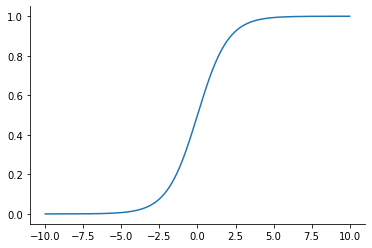

In [5]:
plt.plot(x, sigmoid_np(x))

However, there are some (not at all obvious) performance issues with this `sigmoid`.

#### Problem 1

Is it running on the CPU when it could be running much faster on a GPU. In fact, most, if not all, scientific and machine learning worloads out there run on an accelerator instead of the CPU. Even though the BLAS library is highly optimized, it simply cannot compete with highly parallel processors.

#### Problem 2

Each operation in our function (negation, exponentiation, sum, division, etc) takes the input arrays, allocates a new intermediate array to hold the result, and then actually execute the operation. In other words, the operations are done out-of-place rather than in-place. The overhead of doing a lot of intermediate allocations severely impacts performance in a negative way. Notice how this is not really obvious by glancing the code above! The programmer would have to understand the implementation details to spot this problem.

#### Problem 3

Even though the BLAS kernels are already compiled and optimized, they cannot be optimized *together*. When Python interprets the sigmoid expression, it calls each Numpy function sequentially, retrieving the intermediate results. Perhaps if there existed a "global" view of all the operations together, they could be further optimized, technique called "interprocedural optimization" in compiler theory.

<hr />

It is in this context that JAX comes to our rescue. The library is capable of solving all these problems for us while requiring minimal code changes. Take a look at the following example.

In [6]:
import jax.numpy as jnp # By convention we alias this namespace to `jnp`.

In [7]:
def sigmoid_jax(x):
    """Sigmoid activation function using JAX Numpy API."""
    return 1 / (1 + jnp.exp(-x))
#                   ======= (A) Note the use of `jnp` instead of `np`!

In [8]:
t['jax'] = %timeit -o -r 10  sigmoid_jax(x).block_until_ready()
#                                           =================
#                                     (B) This did not exist before!

410 µs ± 204 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


We can measure a speedup right off the bat! Why is that so? It is because JAX is running this code on an NVIDIA GPU (GTX 1060) instead of the x86 processor. If you do not have an NVIDIA GPU available, you may not see a difference in time here.

But there are some code changes:

- **(A)** We are using the API provided by JAX instead of regular Numpy. It can automatically invoke the appropriate kernel depending on the backend we are using (CPU, GPU, or TPU).

- **(B)** Operations in JAX are asynchronous, therefore we need to insert synchronization calls in order to make the host wait for the results to be ready on the device.

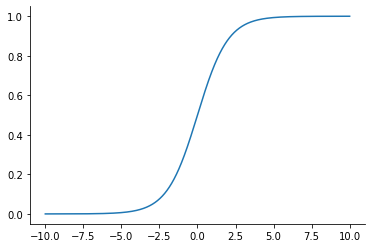

In [9]:
plt.plot(x, sigmoid_jax(x))

The graph looks the same, that's great news.

Calculating the speedup we get:

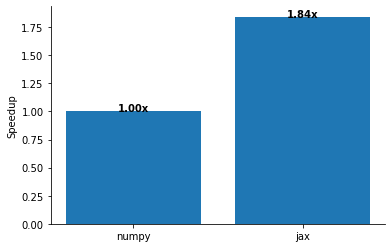

In [10]:
speedup.plot(t)

We can observe close to 2x speedup. Not bad for some trivial code changes! But, can we do better?

When we created the array `x`, Numpy obviously allocated all the data in host (main) memory. But since JAX is running on the GPU, it must first copy this data over to GPU memory before actually invoking the function. To eliminate the need for copying this data every time, we can use the function `device_put`.

In [11]:
from jax import device_put

# Create a copy of `x` in the accelerator memory
dev_x = device_put(x)

# Call `sigmoid_jax` using the device array
t['jax_nocopy'] = %timeit -o -r 10  sigmoid_jax(dev_x).block_until_ready()
#                                               =====

230 µs ± 31.3 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


We can see that the type of our new array is `DeviceArray` as opposed to Numpy's `ndarray`.

In [12]:
print(f"type(x)     = {type(x)}")
print(f"type(dev_x) = {type(dev_x)}")

type(x)     = <class 'numpy.ndarray'>
type(dev_x) = <class 'jaxlib.xla_extension.DeviceArray'>


Again, let us see how the speedup is going.

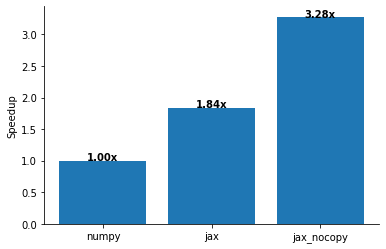

In [13]:
speedup.plot(t)

I am getting close to 5x speedup! How cool is that, five times better with little effort! To conclude this first section, I hope I have convinced you the power JAX brings to the table due to its simplicity, allowing useres with little parallel computing experience to harness the power of accelerators. We move our attention to JIT compiling in the next section.

As a bonus tip, we can use the device array normally as any other array in Python. The data is transferred to the host on-demand when we try to read it.

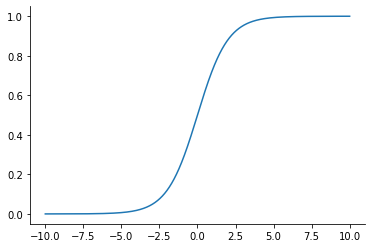

In [14]:
plt.plot(dev_x, sigmoid_jax(dev_x))

<hr />

## JIT

As we all know well, Python is an interpreted language. While interpreted languages are not known for their high performance, these lantiages are usually much easier to work with because of the flexibility dynamic typing provides. But what do we do when we want to have both flexibility and performance? First, not every line of code is created equal: usually a small part of the program (*i.e.* some tight loop nest) takes up the majority of runtime. This is specially true in machine learning and scientific computing.

In this sense, we could have the majority of our code written in a high-level language and only implement the *heavy* part in a compiled language for extra speed. Even better than this, we could write the heavy loop in Python too but find out some way of compiling only this function during runtime, and invoke it immediately. This  is called just-in-time compiling and is exactly what JAX does!

The library provides a series of *function transformations* where we feed a function we wrote and the library returns a new function. What this new function does depends on what the transformation is all about! We first import the [`jit`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html) transformation.

In [15]:
from jax import jit

Next, we transform our sigmoid function.

In [16]:
sigmoid_jax_jit = jit(sigmoid_jax)
#                 ===

The symbol `sigmoid_jax_jit` is now callable.

In [17]:
t['jax_jit'] = %timeit -o -r 10  sigmoid_jax_jit(dev_x).block_until_ready()
#                                ===============

36.5 µs ± 2.49 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


JIT compiling a function is as simple as wrapping it inside `jit`. In the example above `sigmoid_jax_jit` is a new function and can be called exactly the same way as before JIT'ing. Alternatively, instead of calling the `jit` function, we could use it as a decorator to our own functions.

In [18]:
@jit # Decorators look much cleaner!
def sigmoid_jax_jit(x):
    """Jitted sigmoid function using decorator syntax."""
    return 1 / (1 + jnp.exp(-x))

And now for  the speedup:

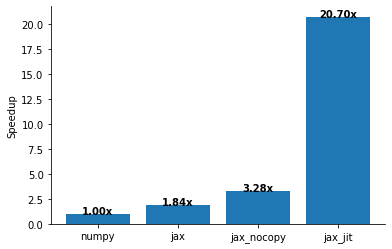

In [19]:
speedup.plot(t)

More than 20x, now that's **fast**. In order to compile and optimize functions, JAX uses the XLA (Accelerated Linear Algebra) compiler, also developed by Google, that powers the TensorFlow framework. In order to achieve this, JAX has a tracing mechanism that creates an abstract representation of your function, hands it to XLA which then compiles and optimize it. The result is a very fast code with almost native performance.

Just to be sure, let's check if the results are close.

In [20]:
assert np.allclose(sigmoid_np(x), sigmoid_jax_jit(x))

Cool.

It is also important to mention that the compiled function is cached, meaning that the first invocation should take a longer time because it needs to trace, compiler, yada yada. Subsequent invocations just straight up invoke the binary code. Paying the price of compile once is usually worth it because since this is hot code, we expect to call this function many many times. Pay attention to the following snippet.

In [21]:
@jit
def f(x):
    print(f"Inside function: x = {x}")
    return x + 1.0

print("=== FIRST  " + "=" * 30)
print(f(1.0))

print()
print("=== SECOND " + "=" * 30)
print(f(1.0))

=== FIRST  ==============================
Inside function: x = Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
2.0

=== SECOND ==============================
2.0


There are a couple of things to unpack here. Notice in the first invocation, we call `f` with `x = 1` but the print actually shows `Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>` instead of the value. Also note in the second invocation that nothing is printed inside the function at all. What is going on?

Remember when we talked about JAX *tracing* the function? That is exactly what is happening in the first invocation. Tracing and compilation happens only once, then on the second invocation the cached binary is used. The tracing mechanism will be studied in the next lecture, so don't worry about that scary string for now.

But there is still something unneasing... why wasn't the `print` compiled into the binary, then? That is because JAX expect **pure** functions: a function  that given the same inputs, always produce the same outputs. In other words, the function must not have side-effects, examples include: interacting with global variables, reading and writing to files, etc. Print statements are just examples of writing to files (`stdout` in this case), and are thus considered side-effects. We are going to explore this and other caveats in the following sections.

### Caveat 1: Pure Functions

If it is so simply as to add a `@jit` on top of functions, why don't we simply do it for all functions in our program and call it a day? Not so fast. If your function is not pure, weird behavior can occur. Consider the `impure_f` function below that reads from a global variable.

In [22]:
g = 10

@jit
def impure_f(x):
    """Impure function that reads from global variable."""
    return x + g

# Call function while `g` is still equals 10
print("(A)", impure_f(1))

# Mutate the global state!
g = 20

# Call function again after mutating `g`
print("(B)", impure_f(1))

(A) 11
(B) 11


Common sense would tell us that the result of the second invocation should be 21 and not 11. However, when JAX compiled this function, it treated `g` as a constant and propagated its value directly into the binary. Global variables are considered side-effects: given the same inputs the function may return different results depending on the value of the global variable. In order to make this function pure, `g` must be passed as an argument.

In [23]:
g = 10

@jit
def pure_f(x, g):
    """Function without side-effects, its result is
    computed solely from the inputs."""
    return x + g

# Call function but explicitly passing `g` this time
print("(C)", pure_f(1, g))

# Mutate global state!
g = 20

# Call function again, the results should be correct now
print("(D)", pure_f(1, g))

(C) 11
(D) 21


### Caveat 2: Tensor Sizes

Earlier we saw how JAX caches the compiled binary for subsequent invocations. However, it trigger a recompilation if the shapes of the input tensors change. This is not a bug but a design feature: knowing tensor sizes during compile time enables more optimizations to be carried out. Allow me to demonstrate.

In [24]:
@jit
def f(x):
    print(f"Compiling! x.shape = {x.shape}")
    return 2.0 * x + 1.0

# First invocation, compilation will happen unconditionally.
print("A:", f(1.0))
# Tensors are the same shape, reuse binary from cache.
print("B:", f(2.0))
# Tensors are now rank 1, trigger recompilation.
print("C:", f(jnp.array([1.0, 2.0])))
# The first version is still in cache!
print("D:", f(3.0))

Compiling! x.shape = ()
A: 3.0
B: 5.0
Compiling! x.shape = (2,)
C: [3. 5.]
D: 7.0


### Caveat 3: Control Flow

JIT compiling functions with control flow that depend on the value of one of the inputs is forbidden. When this happens, JAX has no way to trace the function properly. At the tracing stage, JAX does not know the values of inputs, only their shapes. An example should clarify this.

In [25]:
@jit
def f(x):
    """Function with allowed control flow."""
    # This for statement is control flow that does not depend on `x`,
    # therefore it is allowed.
    for i in range(3):
        x = 2 * x
    return x

print(f(3))

24


In [26]:
@jit
def g(x):
    """Function with control flow that depends on values."""
    # Function cannot be traced because we don't know the value
    # of `x` when tracing.
    if x > 0:
        return 2 * x ** 2 - 1
    else:
        return -x
   
try:
    print(g(1))
except Exception as e:
    print(f"Error: {e}")

Error: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function g at /tmp/ipykernel_21061/2089119459.py:1 for jit, this concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError


You must be asking yourself "how am I supposed to write my code without control flow?". The answer for that is to use JAX structured control flow functions, like shown [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#structured-control-flow-primitives).

### Caveat 4: Immutability

Contrary to Numpy arrays, JAX arrays are immutable. The following code is allowed in Numpy:

In [27]:
np_array = np.zeros((3, 3))

print("Original Numpy array:")
print(np_array)

np_array[1, :] = 1.0
print("\nNumpy array after update:")
print(np_array)

Original Numpy array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Numpy array after update:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


But something similar in JAX throws an exception.

In [28]:
jax_array = jnp.zeros((3, 3))

print("Original JAX array:")
print(jax_array)

try:
    jax_array[1, :] = 1.0
    print("\nJAX array after update:")
    print(jax_array)
except TypeError as error:
    print(f"\nError: {error}")

Original JAX array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Error: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


We can use the suggestion in the error message and use the `.at[]` object.

In [29]:
# Functional-style array update
updated_jax_array = jax_array.at[1, :].set(1.0)
#                             ==       ===

print("JAX array after update:")
print(updated_jax_array)

print("\nOriginal array still intact:")
print(jax_array)

JAX array after update:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]

Original array still intact:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


However, be mindful that these operations are not in-place by default. In other words, using `.at[].set()` may incur in allocations and memory copies. In some cases, when the update is done inside a JITed function, the optimizer may eliminate redundant allocations/copies, but that is not guaranteed 100% of the cases.

There are still other methods in the `.at[]` object beyond `.set()`, please refer to the documentation for a complete [list](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax.numpy.ndarray.at).

### More Caveats?

There are still other minor caveats to look out to. We restrict ourselves to the three most important ones in this notebook. Nevertheless, the JAX documentation has a nice page to document all [Common Gotchas in JAX](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html). It is highly recommended you read this page before writing your entire codebase.

<hr />

## JAXPR

JAXPRs are short for JAX Expressions, and they are useful to check how JAX is transforming our function under the hood. In order to obtain the JAXPR, we must use the transformation [`make_jaxpr`](https://jax.readthedocs.io/en/latest/_autosummary/jax.make_jaxpr.html).

In [30]:
from jax import make_jaxpr

We need to call the transformed function with real data to obtain the representation.

In [31]:
make_jaxpr(sigmoid_jax)(1.0)

{ lambda ; a:f32[]. let
    b:f32[] = neg a
    c:f32[] = exp b
    d:f32[] = add c 1.0
    e:f32[] = div 1.0 d
  in (e,) }

Here we can see all the "instructions" being applied to the input, one after the other. Also pay attention to the data type: each intermediate value is of type `f32[]`, meaning a single scalar value. Calling the same transformed function with an array of larger size produces a different result.

In [32]:
make_jaxpr(sigmoid_jax)(x)

{ lambda ; a:f32[100000]. let
    b:f32[100000] = neg a
    c:f32[100000] = exp b
    d:f32[100000] = add c 1.0
    e:f32[100000] = div 1.0 d
  in (e,) }

Each variable is now of type `f32[100000]`, which is exactly the size of the array `x`. This is in line with our previous discussion of compiling a function assuming the shapes are static.

It is also possible to write your own interpreters of JAXPR! This topic is beyond the scope of this class, but we refer the interested reader to this [notebook](https://jax.readthedocs.io/en/latest/notebooks/Writing_custom_interpreters_in_Jax.html).

<hr />

## Batching

JAX also provides transformations for applying functions in a batch of data. They are the [`vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) transformation for vectorization and [`pmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html) transformation for parallelization.

In [33]:
from jax import vmap, pmap

Vectorization consists of applying the same function to a batch of data in a SIMD fashion. This is going to become clear with an example.

In [34]:
# Create dummy data we can work with
# - Array has 5 rows and 3 columns
A = np.ones((5, 3))
A

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

We vectorize the `jnp.sum` function on the matrix `A`. Note that are many ways to apply a function to a matrix: apply the function by rows, apply the function by columns, apply the function by element, etc. By default, `vmap` uses the first axis in the array. In the 2D, the function is applied row by row.

In [35]:
# Sums the matrix A by rows
vmap(jnp.sum)(A)

DeviceArray([3., 3., 3., 3., 3.], dtype=float32)

To apply the batched function by columns, we specify the input axes to be 1.

In [36]:
# Sums the matrix A by columns
vmap(jnp.sum, in_axes=1)(A)
#             =========

DeviceArray([5., 5., 5.], dtype=float32)

The `pmap` transformation works similarly to `vmap`, but it vectorizes across multiple devices. Because it is unlikely that you and I have multiple GPUs at home, we can't demonstrate that here. However, `pmap` interface is identical to `vmap` in case you have an opportunity to test it! JAX will add collective communication primitives to ensure devices can share data.

In [37]:
from jax import devices

# Retrieve a list of JAX devices
devs = devices()

# Prints devices
print(f"Number of available devices: {len(devs)}")
for dev in devs:
    print(f" - {dev}")

# Attempt to use pmap with a single GPU produces an error
try:
    pmap(jnp.sum)(A)
except ValueError as error:
    print(f"\nError: {error}")

Number of available devices: 1
 - gpu:0

Error: compiling computation that requires 5 logical devices, but only 1 XLA devices are available (num_replicas=5, num_partitions=1)


<hr />

## Auto-differentiation

It is possible to compute the gradient (*i.e.* the derivative) of python functions using JAX auto-diff transformations, [`grad`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html), [`jacfwd`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jacfwd.html), [`jacrev`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jacrev.html), [`hessian`](https://jax.readthedocs.io/en/latest/_autosummary/jax.hessian.html), and the more general [`jvp`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jvp.html) and [`vjp`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vjp.html).

In [38]:
from jax import grad, value_and_grad, jacfwd, jacrev, hessian, jvp, vjp

Let's start with the simple case, compute the derivative of the our `sigmoid` function. Deriving this function manually we arrive at:

$$
\frac{d\sigma(x)}{dx} = \sigma(x) (1 - \sigma(x))
$$

In [39]:
sigmoid_prime = grad(sigmoid_jax)
#               ====

def sigmoid_prime_np(x):
    """Manually written sigmoid prime in Numpy."""
    s = sigmoid_np(x)
    return s * (1 - s)

We have implemented the derivative manually using regular Numpy so we can compare later.

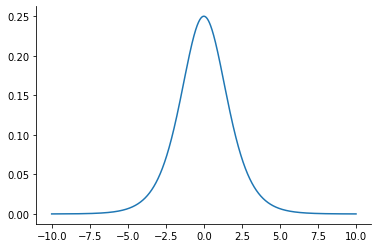

In [40]:
plt.plot(x, vmap(sigmoid_prime)(x))

And this graph is exactly what we expect of $\sigma'(x)$. It also agrees with Numpy:

In [41]:
assert np.allclose(sigmoid_prime_np(x), vmap(sigmoid_prime)(x))

As can be seen in the JAXPR of `sigmoid_prime`, there are a lot more instructions. Closely following the instructions, it can be verified that the JAXPR below is computing the expression:

$$
    \frac{e^{-x}} { (1 + e^{-x})^2}
$$

Which is exactly the derivative of the sigmoid function (click [here](https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e) for a step-by-step demonstration).

In [42]:
make_jaxpr(sigmoid_prime)(1.0)

{ lambda ; a:f32[]. let
    b:f32[] = neg a
    c:f32[] = exp b
    d:f32[] = add c 1.0
    _:f32[] = div 1.0 d
    e:f32[] = integer_pow[y=-2] d
    f:f32[] = mul 1.0 e
    g:f32[] = mul f 1.0
    h:f32[] = neg g
    i:f32[] = mul h c
    j:f32[] = neg i
  in (j,) }

Be mindful that in order for the `grad` and related transformations to work, you must work with the JAX Numpy API (*i.e.*, regular Numpy won't work here).

Autodiff does not seem like much, especially since the sigmoid derivative is widely known, however, having these transformations makes the code more expressive and easier to reason about. Besides, it removes the burden of manually derivating functions that may or may not be trivial to calculate.

If the function has several parameters, you can choose which variable to take the derivative with respect to, or potentially all of them at the same time. Consider the function $f(x, y) = 2 x^2 + xy - 1$. Its gradient is given by:

$$
    \nabla f = (4x + y, x)
$$

Thus, $\nabla f(1, 2) = (6, 1)$. Let's verify that with code:

In [43]:
def f(x, y):
    return 2. * x ** 2. + x * y - 1.

f_prime = grad(f, argnums=(0, 1))
#                 ~~~~~~~~~~~~~~
#           Derivate w.r.t both x and y.

# This function now returns two numbers:
# - Derivative w.r.t. x; and
# - Derivative w.r.t. y.
jit(f_prime)(1.0, 2.0)

(DeviceArray(6., dtype=float32),
 DeviceArray(1., dtype=float32, weak_type=True))

JAX transformations are composable, meaning you can use `jit` and `grad` (and others, for that matter) in any order.

In [44]:
sigmoid_prime = jit(vmap(grad(sigmoid_jax)))
sigmoid_prime_prime = jit(vmap(grad(sigmoid_prime)))
# You can grad(grad(grad(...))) as many times you want!

Sometimes we wish to obtain both the value of the funtion and its gradient at the same time. For that we use `value_and_grad`.

In [45]:
f_value_and_grad = value_and_grad(f, argnums=(0, 1))(1.0, 2.0)

assert f_value_and_grad == (3., (6., 1.))
#                           |    |   |
#                           |    |   `-> df/dy evaluated at (1, 2)
#                           |    `-> df/dx evaluated at (1, 2)
#                           `-> f evaluated at (1, 2)

What about the other transformations? The examples above is simple because we are working with scalar-valued functions. Now suppose we are working with a function $f : \mathbb{R}^n \to \mathbb{R}^m$. There are $n$ inputs and $m$ outputs such that and we need to specify which function should be derived and with respect to which variable. Suppose $f$ is given by:

$$
    \vec{y} = f(\vec{x}) = (f_1, \dots, f_m)
$$

where $\vec{x} = (x_1, \dots, x_n)$ and $f_i : \mathbb{R}^n \to \mathbb{R}, \,\forall i = 1, \dots, m$. In mathematics, there exists the [Jacobian matrix](https://www.wikiwand.com/en/Jacobian_matrix_and_determinant) which is defined as:

$$
    J_f = \begin{bmatrix}
        \frac{\partial f_1}{\partial x_1} & \ldots & \frac{\partial f_1}{\partial x_n} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial f_m}{\partial x_1} & \ldots & \frac{\partial f_m}{\partial x_n}
    \end{bmatrix}
$$

> **Example**. Let $g(x_0, x_1) = (2 x_0 + x_1, x_0 {x_1}^2 - 3)$. Computing the Jacobian matrix of $g$ evaluated at a point $a = (1, 3)$ we get:
> 
> $$
    J_g(x_0, x_1) = \begin{bmatrix}
        2 & 1 \\
        {x_1}^2 & 2 x_0 x_1
    \end{bmatrix} \bigg\rvert_{(1, 3)}
    = \begin{bmatrix}
        2 & 1 \\
        9 & 6
    \end{bmatrix}
$$

There are two methods for computing the Jacobian: `jacfwd` and `jacrev`, short for Jacobian forward mode, and Jacobian reverse mode, respectively. They should always return the same result.

In [46]:
def g(x: jnp.array):
    """Function with multiple inputs and multiple outputs."""
    return jnp.array((2 * x[0] + x[1], x[0] * x[1] ** 2 - 3))
#                     ===============  ====================
#                      First output       Second output

# Compute the jacobian both modes
# ---------------------------------------------------------
a     = jnp.array([1., 3.])
J_fwd = jacfwd(g)(a)
#       ======
J_rev = jacrev(g)(a)
#       ======

# Print the result
# ---------------------------------------------------------
print(f"Jacobian of g evaluted at {a}:\n{J_fwd}")

Jacobian of g evaluted at [1. 3.]:
[[2. 1.]
 [9. 6.]]


The computed result agrees with our manual computations.

In [47]:
assert np.allclose(J_fwd, J_rev)

And the result from both modes match indeed! But why do we need two methods that compute the same thing? It turns out that `jacfwd` computes the Jacobian matrix column-by-column. If the number of outputs if very large, *i.e.* $m \gg n$, then the matrix will be tall and thin such that computing the full-jacobian will be very inefficient. The other alternative is to use `jacrev` which computes the same matrix but row-by-row this time. As a rule of thumb, given a function $f : \mathbb{R}^n \to \mathbb{R}^m$, use:

- `jacfwd` if $m \gg n$; or
- `jacrev` if $n \gg m$.

In machine learning, workloads usually involve computing the gradient of some loss function that takes as input the activations of the last layer and all the weights and biases in the network and returns a single scalar. Therefore, the funtion has potentially millions of inputs and a single output, making the reverse mode more appropriate most of the time.

We can also compute the [Hessian matrix](https://www.wikiwand.com/en/Hessian_matrix) using the `hessian` transformation. Let $f : \mathbb{R}^n \to \mathbb{R}$, the Hessian matrix of $f$ is defined as:

$$
    H_f = \begin{bmatrix}
        \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 x_2} & \dots & \frac{\partial^2 f}{\partial x_1 x_n} \\
        \frac{\partial^2 f}{\partial x_2 x_1} & \frac{\partial^2 f}{\partial x_2^2} & \dots & \frac{\partial^2 f}{\partial x_2 x_n} \\
        \vdots & \vdots & \ddots & \vdots \\
        \frac{\partial^2 f}{\partial x_n x_1} & \frac{\partial^2 f}{\partial x_n x_2} & \dots & \frac{\partial^2 f}{\partial x_n^2} \\
    \end{bmatrix}
$$

> **Example**. Let $g(x_0, x_1) = {x_0}^2 \sin(x_1)$. Computing the Hessian matrix of $g$ evalutated at $a = (1, \pi/2)$ we obtain:
>
> $$
    H_g(1, \pi/2) = \begin{bmatrix}
        2\sin(x_1) & 2 x_0 \cos(x_1) \\
        2 x_0 \cos(x_1) & -{x_0}^2 \sin(x_1)
    \end{bmatrix} \bigg\rvert_{a = (1, \pi/2)}
    = \begin{bmatrix}
        2 & 0 \\
        0 & -1
    \end{bmatrix}
$$

In [48]:
def g(x: jnp.array):
    return x[0] ** 2 * jnp.sin(x[1])

a = jnp.array([1.0, jnp.pi / 2.])
H = hessian(g)(a)
#   =======

print(f"Hessian matrix evaluated at {a}:\n{H}")

Hessian matrix evaluated at [1.        1.5707964]:
[[ 2.000000e+00 -8.742278e-08]
 [-8.742278e-08 -1.000000e+00]]


Again, the `hessian` transformation agrees with our manual computation, up to floating point accuracy.

In [49]:
assert np.allclose(H, [[2.0, 0.0], [0.0, -1.0]], atol=1e-6)

### How does auto-diff work?

Autodiff is neither numeric differentiation nor symbolic differentiation. It is an algorithm that computes the gradient of the function at the same time it evaluates the function. There are two modes of operation: forward and reverse. The interesting thing is that the backpropagation algorithm that we all are familiar with is just a special case of reverse mode auto-diff. Talking about all the details of the technique is beyong the scope of this course. The interested reader can read the following the following paper:

- Baydin, A. G., Pearlmutter, B. A., Radul, A. A., & Siskind, J. M. (2018). Automatic differentiation in machine learning: a survey. *Journal of Marchine Learning Research*, 18, 1-43. ([PDF](https://www.jmlr.org/papers/volume18/17-468/17-468.pdf)) 

<hr />

## Random Numbers

Random numbers is the only part of JAX that differs from the Numpy API. Numpy RNG engine is stateful, making it incompatible with JAX requirement of pure functions. All the functions needed to work with random numbers can be found in the [`random`](https://jax.readthedocs.io/en/latest/jax.random.html) namespace under `jax`.

In [50]:
from jax import random

To use the RNG functions, we must create a key starting with a seed and pass the key around.

In [51]:
# Pseudo random number generator with a starting seed
key = random.PRNGKey(0)
key

DeviceArray([0, 0], dtype=uint32)

In [52]:
X = random.normal(key, shape=(2, 2))
X, key

(DeviceArray([[ 1.8160863 , -0.75488514],
              [ 0.33988908, -0.53483534]], dtype=float32),
 DeviceArray([0, 0], dtype=uint32))

Notice how the key was **not** modified when we used it, if we call the `normal` function with the same key we will get the same results.

In [53]:
# The results are the same, that's bad!
assert np.allclose(X, random.normal(key, shape=(2, 2)))

In order for this to work, we need to "split" the key in half every time.

In [54]:
# Create two new subkeys by splitting two times
key, subkey_1 = random.split(key)
key, subkey_2 = random.split(key)

# Notice how the original key is now different
print(f"key      = {key}")
print(f"subkey_1 = {subkey_1}")
print(f"subkey_2 = {subkey_2}")

key      = [2384771982 3928867769]
subkey_1 = [2718843009 1272950319]
subkey_2 = [1278412471 2182328957]


See how splitting makes the keys different from each other? If we use it different subkeys in random methods, we should get different results!

In [55]:
X = random.uniform(subkey_1, shape=(2, 2))
Y = random.uniform(subkey_2, shape=(2, 2))

# Now we get different random values!
X, Y

(DeviceArray([[0.87241435, 0.44302094],
              [0.27708054, 0.786595  ]], dtype=float32),
 DeviceArray([[0.47366   , 0.78604746],
              [0.88060236, 0.3833393 ]], dtype=float32))

<hr />

## Beyond `jax.numpy`

Beside the `jax.numpy` submodule, there is also the `jax.scipy` module that implements a subset of functions from the [SciPy](https://scipy.org/) library.

In [56]:
import jax.scipy as jsp

In particular, the `jax.scipy.linalg` module provides many common operations on matrices, like:

- Determinants (`det`);
- Solving linear systems $A \cdot x = b$ for unknown $x$ (`solve`, `solve_triangular`);
- Factorizations (`lu`, `cholesky`, `polar`, `qr`, `schur`, `svd`);
- Inverse (`inv`);
- and more.

In [76]:
M = jnp.array([[1, 3],
               [5, 2]])

assert sp.linalg.det(M) == -13.0

In `jax.scipy.signal` there is also the operators `convolve` (N-dimensional) and `convolve2d` (2-dimensional).

Image shape = (1, 1, 768, 1024)


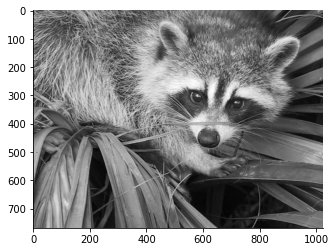

In [142]:
# Load raccoon face image and convert to rank-4 tensor
image = sp.misc.face().mean(-1)
image = image[jnp.newaxis, jnp.newaxis, :, :] / 255.0

print(f"Image shape = {image.shape}")
plt.imshow(image[0, 0], cmap='binary_r')

In [156]:
def create_kernel(size):
    """
    Create a new 2D kernel OIHW layout.
    - O: Output
    - I: Input
    - H: Height
    - W: Width
    """
    return jnp.ones((size, size))[jnp.newaxis, jnp.newaxis, :, :]

kernel = create_kernel(size=32)
print(f"Kernel shape = {kernel.shape}")
print(kernel[0, 0])

Kernel shape = (1, 1, 32, 32)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [128]:
# Specify the input and output layouts of our convolution
dimension = lax.conv_dimension_numbers(
    image.shape,
    kernel.shape,
    ('NHWC', 'HWIO', 'NHWC'))
#     ====    ====    ====
#    Input   Kernel  Output

dimension

ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2))

(1, 1, 768, 1024)


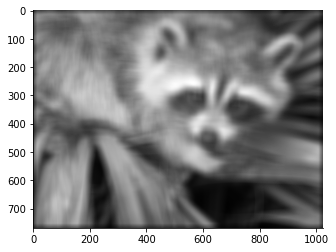

In [157]:
output = lax.conv_general_dilated(
    image,     # LHS of the convolution
    kernel,    # RHS of the convolution
    (1, 1),    # Window stride in each dimension
    'SAME',    # Padding
    (1, 1),    # LHS dilation
    (1, 1),    # RHS dilation
    None       # Input/output dimensions
)

print(output.shape)
plt.imshow(output[0, 0], cmap='binary_r')

For a complete reference, check the JAX documentation of the [`scipy` module](https://jax.readthedocs.io/en/latest/jax.scipy.html).

On the same vein, JAX has a lower-level interface called LAX, which resembles `jax.numpy` but with harder contraints on types. In practice, all `jax.numpy` operations are implemented in terms of LAX primitives.

In [59]:
from jax import lax

For example, operations on mixed types (*e.g.* floating points and integers) are allowed in JAX Numpy but are forbidden in LAX.

In [60]:
# This is allowed...
assert jnp.add(1.0, 1) == 2.0

try:
    # ...while this is not! 
    print(lax.add(1.0, 1))
except TypeError as error:
    print(f"Error: {error}")

Error: lax.add requires arguments to have the same dtypes, got float32, int32. (Tip: jnp.add is a similar function that does automatic type promotion on inputs).


TODO

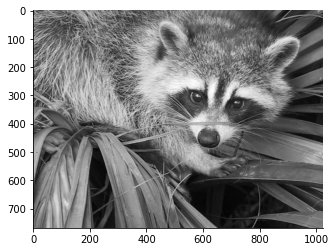

In [63]:
image = sp.misc.face().mean(-1)
plt.imshow(image, cmap='binary_r')

In [69]:
def smooth_image(image, ksize):
    kernel = jnp.ones(ksize ** 2).reshape(ksize, ksize)
    return jsp.signal.convolve2d(image, kernel)

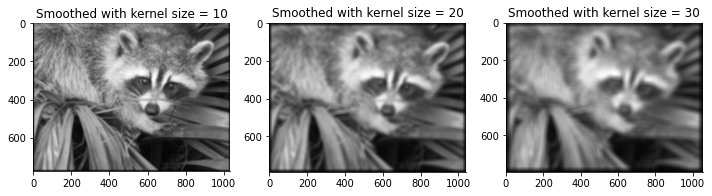

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for i in range(3):
    ksize = 10*(i+1)
    smoothed = smooth_image(image, ksize)
    ax[i].imshow(smoothed, cmap='binary_r')
    ax[i].set_title(f"Smoothed with kernel size = {ksize}")

<hr />

The end!